# **RAC 캐시 퓨전이란?**

- 데이터베이스를 물리적으로 분할하여 분산하는 방식이 아닌, 데이터베이스를 하나로 두되 이를 액세스하는 인스턴스를 여러 개 두는 공유 디스크(Shared Disk)방식의 데이터베이스 클러스터링 기법.

**캐시퓨전(Cache Fusion)**

- 공유디스크 방식에 기반을 두면서 인스턴스 간에 버퍼캐시까지 공유하는 기술.
- RAC 모델특성 상 튜닝이 잘 되지 않아서 많은 블록I/O를 일으키는 애플리케이션에서 RAC를 도입하면, 단일 인스턴스 환경에서보다 더욱 심각한 성능 저하 현상이 일어남.
- 성능문제를 해결하기 위해서는 캐시퓨전 프로세싱 원리를 이해할 필요가 있음.

**글로벌 캐시**

- 클러스터링 되어있는 모든 인스턴스 노드의 버퍼캐시를 하나의 버퍼캐시로 간주.
- 모든 데이터 블록에 대해서 마스터 노드가 각각 정해져 있음.
- 그 노드를 통해서 글로벌 캐시에 캐싱되어 있는 블록의 상태와 Lock정보를 관리

**Current 블록**
- 디스크로부터 읽혀진 후 사용자의 갱신사항이 반영된 최종 상태의 원본 블록.

1. **Shared 모드 Current(SCur)**
  - 자주 읽히는 데이터 블록은 각 노드가 SCur 모드로 캐싱하고 있을 때 가장 효율적.
  - 그 중 한노드가 XCur 모드로 업그레이드 요청하는 순간 다른 노드에 캐싱돼 있던 SCur 블록들은 모두 NULL 모드로 다운그레이드됨.

2. **Exclusive 모드 Current(XCur)**
  - 동시에 여러 노드에 캐싱될 수 있지만, XCur상태의 블록은 단 하나의 노드에만 존재.

# **전송 매커니즘**

**RAC 노드간 버퍼캐시를 공유하면서 블록을 서로 주고받는 전송 매커니즘은 5가지로 나누어 설명**

### **1. 전송 없는 읽기: Read with No Transfe**

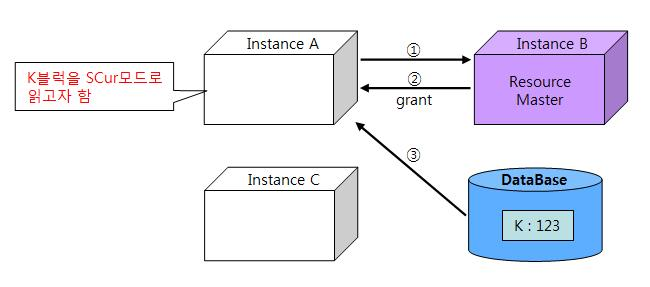

- 순서
  1. A노드에서 K 블록을 읽으려는 시도.
  2. A노드는 그 블록의 리소스 마스터인 B 노드에게 전송 요청을 보냄.
  (이때 gc cr request 이벤트에서 대기한다.)
  3. B노드는 현재 어떤 노드에도 K블록을 캐싱하고 있지 않음을 확인하고 A노드에게 데이터파일에서 직접 블록을 SCur 모드로 읽도록 권한을 부여.
  4. A노드는 디스크에서 블록을 읽어 로컬 캐시에 캐싱.

- 요약
> A(요청) >> B(부여) >> A(디스크읽기) >> 디스크(K블록)

### **2. 읽기/읽기 전송 : Read to Read Transfer**

- (1)의 상태에서 C노드가 같은 K블록을 SCur 모드로 읽으려고 한다고 가정

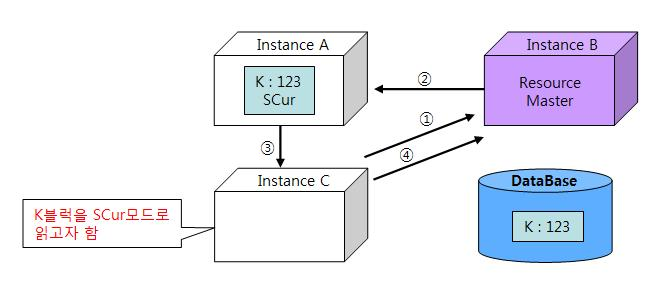

- 순서
  1. C노드는 리소스 마스터인 B노드에게 K블록에 대한 전송 요청을 보냄.
  2. B노드는 현재 K블록을 A노드가 캐싱하고 있음을 확인하고 C노드에 블록을 전송해 주도록 A노드에게 지시.
  3. A노드는 C노드에게 블록을 전송.
  4. C노드는 블록을 성공적으로 전송받아 SCur 모드로 캐싱하게 되었음을 알리려고 마스터 노드인 B에게 메시지를 보냄.
  
- 요약
> C(요청) >> B(지시) >> A(전송) >> C(알림) >> B

### **3. 읽기/쓰기 전송 : Read to Write Transfer**
- (2)의 상태에서 C노드가 K블록을 XCur 모드로 업그레이드하려고 한다고 가정

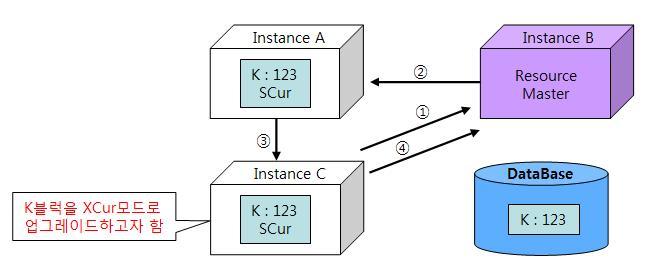

- 순서
  1. C노드는 마스터 노드인 B에게 K블록을 XCur 모드로 업그레이드하겠다고 요청.
  2. B노드는 현재 K블록을 A노드도 캐싱하고 있음을 확인하고 Null 모드로 다운그레이드하도록 지시.
  3. A노드는 C노드에게 Null 모드로 다운그레이드 했음을 알려줌.
  4. C노드는 K블록을 XCur모드로 업그레이드하고 그 결과를 마스터 노드인 B에게 알려줌. 이때 A노드의 K블록이 Null 모드로 다운그레이드 된것까지 함께 알려줌.
  5. C노드의 K블록 SCN이 123 -> 154로 증가.
  
- 요약
> C(요청) >> B(지시) >> A(알림) >> C(알림 WITH A 상태) >> B



### **4. 쓰기/쓰기 전송 : Write to Write Transfer**

- (3)의 상태에서 A노드가 K블록을 XCur모드로 읽으려고 한다고 가정.


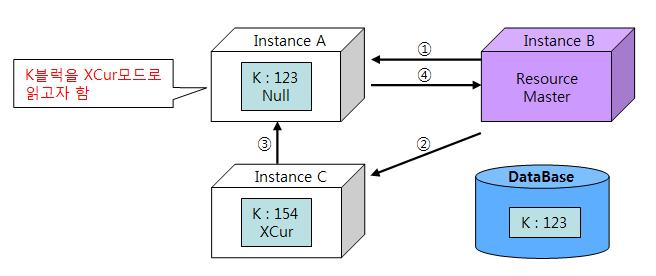

- 순서
  1. A노드는 마스터 노드인 B에게 K블록을 XCur 모드로 요청.
  2. B노드는 현재 K블록을 C노드가 XCur 모드로 캐싱하고 있음을 확인하고 A노드에게 보내주도록 지시.
  3. C노드는 A노드에게 블록을 전송하고 자신이 갖고 있던 블록은 Null 모드로 다운그레이드함.
  4. A노드는 K블록을 XCur 모드로 캐싱하게 됐음을 B노드에게 알려줌.
  5. A노드의 K블록 SCN이 154 -> 168로 증가.

- 요약
> A(요청) >> B(지시) >> C(전송) >> A(알림) >> B

- 이 때 다른 인스턴스가 갱신 중인 블록을 읽고자 할 때 로우 Lock이 해제될 때까지 기다리지 않고 로우Lock이 설정된 채, 블록을 주고 받음.

### **5. 쓰기/읽기 전송 : Write to Read Transfer**

- (4)의 상태에서 C노드가 K블록을 SCur모드로 읽으려고 한다고 가정.
- 쓰기/읽기 캐시 퓨전 원리를 이해한다면 RAC를 구성할때 데이터를 가공하는 노드와 읽는 노드를 서로 분리하는 것이 성능에 얼마나 안 좋은 영향을 끼칠지 예상할 수 있음.

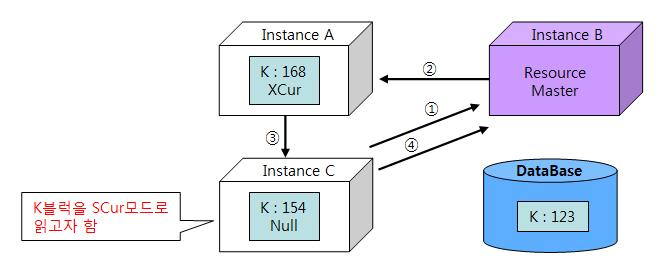

- 순서
  1. C노드는 마스터 노드인 B에게 K블록을 SCur 모드로 요청.
  2. B노드는 현재 K블록을 A노드가 XCur 모드로 캐싱하고 있음을 확인하고 C노드에게 보내주도록 지시.
  3. A노드는 C노드에게 블록을 전송하고 자신일 갖고 있던 블록은 SCur모드로 다운그레이드.
  4.  C노드는 K블록을 SCur모드로 캐싱하게 됐음을 B노드에게 알려줌. 이때 A노드에 캐싱돼 있던 블록이 SCur모드로 다운그레이드된 사실까지 함께 알려줌.

- 요약
> A(요청) >> B(지시) >> C(전송) >> A(알림) >> B

- 쓰기/읽기 전송일경우 K블록의 커밋여부에 따라 처리가 다름.
  - 커밋하지 않았으면 Current블록을 보내지 않고 CR Copy를 만들어 전송한다.
    - 커밋을 하지 않았다는 것은 아직 갱신이 진행중임을 의미.
    - current 블록을 보내면 다시 가져오고 캐싱모드를 업그레이드/다운그레이드 하는 일이 자주 발생.
    - RAC부하가 증가하므로 이러한 부하 발생 가능성을 최소화 하기위해 일정횟수만큼 CR Copy만을 보내주는 방식을 사용.
  - 커밋되었다면 일정 횟수까지는 CR Copy를 전송하고, 일정 횟수가 넘어가면 Current 블록을 전송.
  - _fairness_threshold 파라미터
  CR Copy를 보내는 횟수를 설정하는 파라미터로 디폴트 값은 4.

# **dynamic remastering**

- 리소스 친화도에 따라 마스터 노드가 동적으로 변할 수 있음.
  - 리소스의 OwnerShip은 A가 가지고 있으나, B가 반복적으로 요청한다면, 해당 리소스의 마스터 노드가 B로 변경될 수 있다는 것.
- 자주 사용하는 리소스를 자신이 직접 관리하므로 RAC 성능 향상에 도움을 줌.
- _gc_affinity_time 히든 패러미터를 사용.
  - 10g RAC의 경우 dynamic remastering 기능을 사용하지 않을 수 있음.
  - 11g의 경우 관련 패러미터의 이름이 바뀜.
